# Using CrUX data for better performance visualization

In [ ]:
import pandas as pd
import decimal

In [ ]:
%%bigquery results --project tai-test

SELECT * FROM `chrome-ux-report.country_jp.202311` WHERE origin = 'https://www.akamai.com'

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
results.head()

,origin,effective_connection_type,form_factor,first_paint,first_contentful_paint,largest_contentful_paint,dom_content_loaded,onload,first_input,layout_instability,interaction_to_next_paint,experimental
0,https://www.akamai.com,{'name': '4G'},{'name': 'desktop'},"{'histogram': {'bin': [{'start': 0, 'end': 100...","{'histogram': {'bin': [{'start': 0, 'end': 100...","{'histogram': {'bin': [{'start': 0, 'end': 100...","{'histogram': {'bin': [{'start': 0, 'end': 100...","{'histogram': {'bin': [{'start': 0, 'end': 100...","{'delay': {'histogram': {'bin': [{'start': 0, ...",{'cumulative_layout_shift': {'histogram': {'bi...,"{'histogram': {'bin': [{'start': 0, 'end': 25,...","{'permission': None, 'time_to_first_byte': {'h..."
1,https://www.akamai.com,{'name': '4G'},{'name': 'phone'},"{'histogram': {'bin': [{'start': 0, 'end': 100...","{'histogram': {'bin': [{'start': 0, 'end': 100...","{'histogram': {'bin': [{'start': 0, 'end': 100...","{'histogram': {'bin': [{'start': 0, 'end': 100...","{'histogram': {'bin': [{'start': 600, 'end': 7...","{'delay': {'histogram': {'bin': [{'start': 0, ...",{'cumulative_layout_shift': {'histogram': {'bi...,"{'histogram': {'bin': [{'start': 0, 'end': 25,...","{'permission': None, 'time_to_first_byte': {'h..."
2,https://www.akamai.com,{'name': '3G'},{'name': 'desktop'},"{'histogram': {'bin': [{'start': 0, 'end': 100...","{'histogram': {'bin': [{'start': 0, 'end': 100...",None,None,None,None,{'cumulative_layout_shift': {'histogram': {'bi...,None,"{'permission': None, 'time_to_first_byte': {'h..."


In [ ]:
def find_histogram(df, hist=None):
  """Find histogram within GBQ CrUX dataset"""
  if not hasattr(df, 'keys'): return
  if hist is None: hist = []

  for i in df.keys():
    if i == 'histogram':
      # create label name from access path
      col = "_".join([i for i in hist if type(i) is str])
      yield col, pd.DataFrame.from_records(df[i]['bin'])
      return

    # dig deeper
    hist.append(i)
    yield from find_histogram(df[i], hist)
    hist.pop()

def get_histogram(results):
  """Returns a clean dataframe from histograms in CrUX data"""

  # merge all histograms into one dataframe
  def find_histogram_wrapper(results):
    for i, df in find_histogram(results):
      df.columns = ['start', 'end', i + "_rv"] # RV for Raw Value
      yield df
  df = pd.concat(find_histogram_wrapper(results))

  # fix start/end as some use Decimal seconds while other use milliseconds
  df['start'] = df.start.apply(lambda v: int(v * 1000) if type(v) is decimal.Decimal else v)
  df['end'] = df.end.apply(lambda v: int(v * 1000) if type(v) is decimal.Decimal else v)

  # merge probability data for each start-end range
  df = df.groupby(['start', 'end']).sum().reset_index()

  # add a helper column useful for filtering in later stage
  df['step'] = df.end - df.start

  # add a CDF value column for each performance data (for easier plotting)
  df.sort_values('end', inplace=True)
  for i in df.columns:
    if i.endswith('_rv'):
      df[i.replace('_rv', '')] = df[i].cumsum()
  return df

df = get_histogram(results)
df.head()

,start,end,first_paint_rv,first_contentful_paint_rv,largest_contentful_paint_rv,dom_content_loaded_rv,onload_rv,first_input_delay_rv,layout_instability_cumulative_layout_shift_rv,interaction_to_next_paint_rv,...,step,first_paint,first_contentful_paint,largest_contentful_paint,dom_content_loaded,onload,first_input_delay,layout_instability_cumulative_layout_shift,interaction_to_next_paint,experimental_time_to_first_byte
0,0,25,0.00000,0.0000,0.00000,0.000,0.0000,0.9145,0.0000,0.1392,...,25,0.00000,0.0000,0.00000,0.000,0.0000,0.9145,0.0000,0.1392,0.00000
1,0,50,0.00000,0.0000,0.00000,0.000,0.0000,0.0000,0.7622,0.0000,...,50,0.00000,0.0000,0.00000,0.000,0.0000,0.9145,0.7622,0.1392,0.00000
3,25,50,0.00000,0.0000,0.00000,0.000,0.0000,0.0356,0.0000,0.3774,...,25,0.00000,0.0000,0.00000,0.000,0.0000,0.9501,0.7622,0.5166,0.00000
4,50,75,0.00000,0.0000,0.00000,0.000,0.0000,0.0112,0.0000,0.1761,...,25,0.00000,0.0000,0.00000,0.000,0.0000,0.9613,0.7622,0.6927,0.00000
2,0,100,0.02435,0.0245,0.02165,0.017,0.0001,0.0000,0.0000,0.0000,...,100,0.02435,0.0245,0.02165,0.017,0.0001,0.9613,0.7622,0.6927,0.07835


<Axes: xlabel='end'>

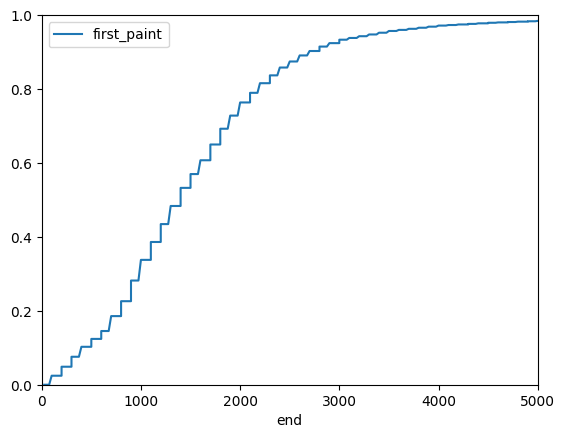

In [ ]:
df.plot(y='first_paint', x='end', xlim=[0, 5000], ylim=[0, 1.0])

<Axes: xlabel='end'>

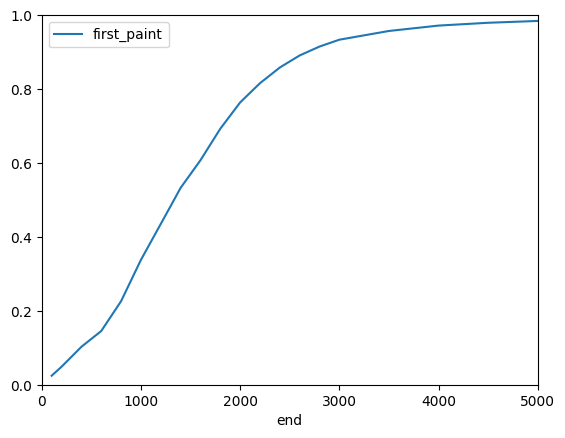

In [ ]:
df[df.step == 100].plot(y='first_paint', x='end', xlim=[0, 5000], ylim=[0, 1.0])

Text(0.5, 1.0, 'Timing Distribution')

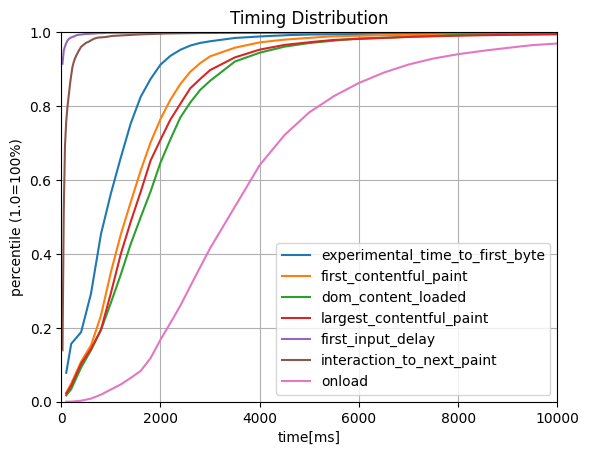

In [ ]:
ax = df[df.step == 100].plot(y='experimental_time_to_first_byte', x='end', xlim=[0, 10000], ylim=[0, 1.0])
df[df.step == 100].plot(y='first_contentful_paint', x='end', ax=ax)
df[df.step == 100].plot(y='dom_content_loaded', x='end', ax=ax)
df[df.step == 100].plot(y='largest_contentful_paint', x='end', ax=ax)
df[df.step == 25].plot(y='first_input_delay', x='end', ax=ax)
df[df.step == 25].plot(y='interaction_to_next_paint', x='end', ax=ax)
df[df.step == 100].plot(y='onload', x='end', ax=ax)

# annotate with AxesSubplot methods
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
ax.grid()
ax.set_ylabel('percentile (1.0=100%)')
ax.set_xlabel('time[ms]')
ax.set_title('Timing Distribution')
